<img src = "imgs/TeS_img.png">

---
* Parte 01: Dados de entrada sobre o sistema reacional

In [601]:
"""
Componentes considerados:

H2O
CH4
CO2
CO
H2

"""

# 1.1. Capacidades caloríficas

# Informações obtidas do livro Introduction of Chemical Engineering Thermodynamics

# Valores de Cp 

         # CPA, CPB, CPC, CPD
CP_data = [[3.47,0.00145,0,12100],               # H2O
           [1.702,0.009081,-0.000002164,0],      # CH4
           [5.457,0.001045,0,-115700],           # CO2
           [3.376,0.000557,0,-3100],             # CO
           [3.249,0.000422,0,8300]]              # H2


O polinômio utilizado para o cálculo das capacidades caloríficas é apresentado na Equação 1.

\begin{equation}
\frac{C_p}{R} = a + b.T + c.T^2 + \frac{D}{T^2} \tag{Eq. 1}
\end{equation}

Essa informação será relevante para o cálculo da energia de Gibbs padrão de formação em função da temperatura.

In [602]:
# 1.2. Propriedades termodinâmicas de formação

# Informações obtidas do livro Introduction of Chemical Engineering Thermodynamics
# deltaH - Entalpia de formação a 298.15 K (J/mol)
# deltaG - Energia de Gibbs de formação a 298.15 K (J/mol)

           # deltaH, deltaG
prop_form = [[-241818,-228572],    # H2O
             [-74520,-50460],      # CH4
             [-393509,-394359],    # CO2
             [-110525,-137169],    # CO
             [0, 0]]               # H2

# 1.3. Propriedades termodinâmicas dos componentes puros

# Informações obtidas do livro Introduction of Chemical Engineering Thermodynamics
# Tc - Temperatura crítica (K)
# Pc - Pressão crítica (bar)
# omega - fator acentrico (-)

           # Pc, Tc, omega
prop_term = [[220.55,647.1,0.345],    # H2O
             [45.99,190.6,0.012],     # CH4
             [73.83,304.2,0.224],     # CO2
             [34.99,132.9,0.048],     # CO
             [13.13,33.19,-0.216]]    # H2

Até este ponto fizemos a inserção das informações necessárias para os cálculos que faremos com o objetivo de minimizar a energia de Gibbs dos sistema.

Como já dito, o objetivo é minimizar a energia de Gibbs e esta será escrita na forma de programação não-linear como apresenta a Equação 2.

\begin{equation}
\min G = \sum_{i=1}^{NC} \sum_{j=1}^{NF} n_i^j \mu_i^j \tag{Eq. 2}
\end{equation}

---
* Parte 02: Cálculo da energia de Gibbs

Tendo as informações apresentadas na **Parte 01**, agora faremos o cálculo da energia de Gibbs. A Equação 3 apresentação a realção entra entalpia e capacidade calorífica.

\begin{equation}
\left( \frac{\partial \bar{H}_i^g}{\partial T} \right) = C_{p,i}^g \quad \text{for } i=1,\ldots,NC

 \tag{Eq. 3}
\end{equation}



Tendo conhecimento da realação da entalpia com a temperatura, o passo seguinte é o cálculo do potencial químico. A Equação 4 apresenta a correlação para o cálculo dos potenciais químicos.

\begin{equation}
\frac{\partial}{\partial T} \left( \frac{\mu_i^g}{RT} \right) = -\frac{\bar{H}_i^g}{RT^2} \quad \text{para } i=1,\ldots,NC
 \tag{Eq. 4}
\end{equation}

Lembrando que o polinômio utilizado para o cálculo da capacidade calorífica foi apresentado na Equação 1.

Assim, a função abaixo (**gibbs_pad**) calcula os potenciais químicos de acordo com a Equação 4.

In [603]:
from scipy.integrate import quad

def gibbs_pad(T, prop_form, CP_data):
    R = 8.314  # J/mol·K
    T0 = 298.15  # Temperatura de referência em Kelvin
    
    results = []

    # Itera sobre as propriedades de formação e os dados de Cp juntos
    for (deltaH, deltaG), (CPA, CPB, CPC, CPD) in zip(prop_form, CP_data):
        # Define a função Cp(T_prime) com base nos dados de CP
        def cp(T_prime):
            return R * (CPA + CPB * T_prime + CPC * T_prime ** 2 + CPD / T_prime ** 2)

        # Inner integral
        def inner_integral(T_prime):
            value, _ = quad(cp, T0, T_prime)
            return (deltaH + value) / T_prime ** 2

        # Outer integral
        integral_value, _ = quad(inner_integral, T0, T)
    
        # Calculating mu_i using the provided formula
        mu_i = T * (deltaG / T0 - integral_value)
        
        results.append(mu_i)

    return results

A função acima faz o seguinte:

\begin{equation}

\mu _i^0 = \frac {T}{T^0}.\Delta G_f^{298.15 K} - T.\int_{T_0}^{T} \frac {\Delta H_f^{298.15 K} + \int_{T_0}^{T} (CPA + CPB \cdot T + CPC \cdot T^2 + \frac{CPD}{T^2}) \, dT}{T^2} dT

 \tag{Eq. 5}
\end{equation}

Bom, agora temos a função que calculo os potenciais químicos. Este código considera somente a formação de componente na fase *g*, assim, a função objetivo (Eq. 2) pode ser reescrita conforme apresena a Equação 6.

\begin{equation}
\min G = \sum_{i=1}^{NC} n_i^g \mu_i^g \tag{Eq. 6}
\end{equation}

Onde:

\begin{equation}
\mu _i^g = \mu _i^0 + R.T.(ln(\phi_i)+ln(P)+ln(y_i)) \tag{Eq. 7}
\end{equation}

Para os calculos dos coeficientes de fugacidade, teremos duas possibilidades:

1. Gás ideal: 

\begin{equation}
\phi = 1 
\tag{Eq. 8}
\end{equation}

2. Gás não ideal:

Será utilizada a equação de estado de Peng-Robinson.

\begin{equation}

\ln\phi = \left(\frac{b_\alpha}{b}\right) (Z_\text{vapor} - 1) - \ln(Z_\text{vapor} - B) + \frac{A}{2\sqrt{2} B} \ln\left(\frac{Z_\text{vapor} + (1 + \sqrt{2}) B}{Z_\text{vapor} + (1 - \sqrt{2}) B}\right)
\tag{Eq. 9}
\end{equation}

Serão calculadas as raízes de Z que é escrito na forma de um polinômio com os coeficientes descritos abaixo:

$$[1, -1, A - B - B^2, -A \cdot B]$$

Assim, será utilizada a raizes positivo do polinômio de Z e esta será utilizada na Equação 9 para o cálculo do coeficiente de fugacidade.

A função abaixo (**fug**) calcula os coeficientes de fugacidade:

In [604]:
import numpy as np

def fug(T, P, eq, n, prop_term):
    P = P * 100000  # bar -> Pa
    mole_fractions = n / sum(n)

    # Cálculo das propriedades da mistura
    Tc = np.dot(mole_fractions, [pt[1] for pt in prop_term])  # Temperatura crítica
    Pc = np.dot(mole_fractions, [pt[0] for pt in prop_term]) * 100000  # Pressão crítica convertida de bar para Pa
    omega = np.dot(mole_fractions, [pt[2] for pt in prop_term])  # Fator acêntrico
    
    R = 8.314  # J/(mol*K)
    
    if eq == 'ideal':
        res = 1  # Para gás ideal, o coeficiente de fugacidade é 1

    elif eq == 'peng_robinson':
        Tr = T / Tc
        Pr = P / Pc
        kappa = 0.37464 + 1.54226 * omega - 0.26992 * omega**2
        alpha = (1 + kappa * (1 - np.sqrt(Tr)))**2
        a = 0.45724 * (R**2 * Tc**2) / Pc
        b = 0.07780 * R * Tc / Pc
        a_alpha = a * alpha
        A = a_alpha * P / (R**2 * T**2)
        B = b * P / (R * T)
        
        # Cálculo do Z (fator de compressibilidade)
        coefficients = [1, -1 + B, A - 3*B**2, -A*B + B**2 + B**3]
        Z_roots = np.roots(coefficients)
        Z = max(Z_roots[np.isreal(Z_roots)])
        
        # Cálculo do coeficiente de fugacidade
        ln_phi = (b / (b * R * T)) * (Z - 1) - np.log(Z - B)
        ln_phi -= A / (2 * np.sqrt(2) * B) * np.log((Z + (1 + np.sqrt(2)) * B) / (Z + (1 - np.sqrt(2)) * B))
        res = np.exp(ln_phi)

    return res


Temos a função que calcula a energia de Gibbs padrão e temos também a função para o cálculo dos coeficientes de fugacidade. O passo seguinte será definir a rotina de otimização.

* Passo 03: Minimização da energia de Gibbs

* 3.1. Definindo a função objetivo:

In [605]:
def gibbs(n, T, P):
    R = 8.314  # J/mol·K
    eq = 'peng_robinson'

    # Garantir que n não tenha valores nulos ou negativos para evitar erros no cálculo do logaritmo
    for i in range(n.shape[0]):
            if n[i] <= 0:
                n[i] = 1e-20

    # Calcular Gibbs padrão de formação a partir da função gibbs_pad
    dfg_gas = gibbs_pad(T, prop_form, CP_data)

    # Calcular o coeficiente de fugacidade para cada componente da mistura
    phii = fug(T, P, eq, n, prop_term)

    # Calcular o potencial químico mi para os gases na mistura
    mi_gas = dfg_gas + R * T * (np.log(phii) + np.log(n / np.sum(n)) + np.log(P))

    # Calcular a energia de Gibbs total
    total_gibbs = np.sum(mi_gas * n)

    return total_gibbs

* 3.2. Definição das restrições:

Conhecemos a função objetivo (Eq. 2), agora precisamos definir as restrições para direcionar a busca pela solução.

O espaço de possíveis soluções deve ser restrito a duas condições:

1. Não negatividade de mols:

$$ n_i^j \geq 0 $$

2. Conservação do número de átomos:

$$ \sum _{i}^{NC} a_{mi} (\sum _{j}^{NF} n_i^j) =  \sum _{i}^{NC} a_{mi} n_i^0 $$


Escrevendo a primeira restrição:

In [606]:
# Quantidade inicial de mols por componente:
#    H2O CH4 CO2 CO H2
n0 = [1,  0.5,  0,  0, 0]

max_C = 0*n0[0]+1*n0[1]+1*n0[2]+1*n0[3]+0*n0[4]
max_H = 2*n0[0]+4*n0[1]+0*n0[2]+0*n0[3]+2*n0[4]
max_O = 1*n0[0]+0*n0[1]+2*n0[2]+1*n0[3]+0*n0[4] 

max_H2O = min(max_O, max_H/2)
max_CH4 = min(max_C, max_H/4)
max_CO2 = min(max_C, max_O/2)
max_CO = min(max_C, max_O)
max_H2 = max_H/2

bnds = ((0, max_H2O), (0, max_CH4), (0, max_CO2), (0, max_CO), (0, max_H2))

No caso acima não só definimos a não negatividade de números de mols, definimos também os limites de formação dos componentes com base na quantidade de átomos.

Escrevendo a segunda restrição:

In [607]:
# Inicialmente definiremos a matriz com as estruturas dos componentes envolvidos na reação:
def element_balance(n,n0):
                           # C  H  O
    A = np.array([
                            [0, 2, 1],  # H2O
                            [1, 4, 0],  # CH4
                            [1, 0, 2],  # CO2
                            [1, 0, 1],  # CO
                            [0, 2, 0]   # H2
                        ])
    return np.matmul(n, A) - np.matmul(n0, A)

# A restrição:
cons = [{'type': 'eq', 'fun': element_balance, 'args': [n0]}]

Assim, definimos ambas as restrições necessárias. Iniciaremos agora a etapa de otimização.

3.3. Otimização:

Utilizaremos a biblioteca `scipy.optimize`.

In [608]:
# Definindo as variáveis de entrada

Tmin = 600
Tmax = 1100
ntemp = 30

P = 1
T = np.linspace(Tmin,Tmax,ntemp) # T in K

In [609]:
from scipy.optimize import minimize
import pandas as pd

result = []
temperature = []

init = [0.5]*5

for j in range(len(T)):
    
    # Perform the optimization.
    sol = minimize(gibbs, init, args=(T[j], P), 
                    method='trust-constr', bounds=bnds, constraints=cons, options={'disp': False, 'maxiter': 1000})

    result.append(sol.x)
    temperature.append(T[j])

Componentes = ['H2O','CH4','CO2','CO','H2']
results = pd.DataFrame(result, columns=Componentes)
results['Temperature (K)'] = temperature

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


* Verificação do número de mols em função da temperatura:

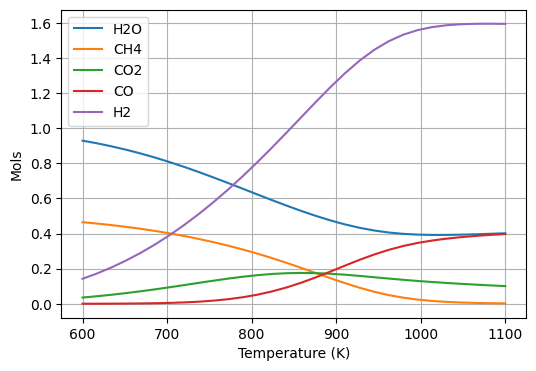

In [610]:
import matplotlib.pyplot as plt

# Definindo 'Temperature (K)' como o índice do DataFrame, se já não estiver definido.
results.set_index('Temperature (K)', inplace=True)

# Iniciando a figura do matplotlib
plt.figure(figsize=(6, 4))

# Plotando cada coluna
for column in results.columns:
    plt.plot(results.index, results[column], label=column)

# Adicionando rótulos e título
plt.xlabel('Temperature (K)')
plt.ylabel('Mols')

# Adicionando a legenda. 'loc' pode ser alterado para posicionar a legenda onde você desejar.
plt.legend(loc='upper left')

# Mostrando o gráfico
plt.grid()
plt.show()